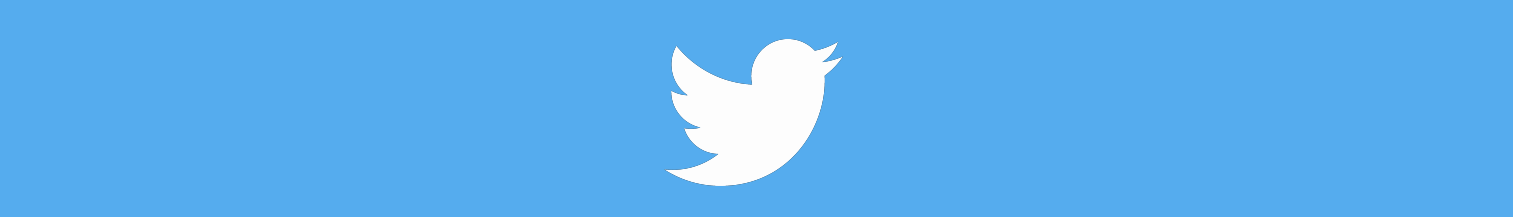

# Natural Language Processing with Disaster Tweets

## Overview

This Notebook will be completed in two main ways.<br/>
First, find and visualize useful data or meaningful relationships within the data.<br/>
Second, select a model based on the visualization of the previous process. Transform or refine the data into the appropriate form for the model to be used.<br/><br/>

This competition is about predicting positive and negative through data.<br/>
That is why we need to go through a careful data preprocessing process.

#### My opinion :
To provide a variety of information to the deep learning model, we will combine the columns 'keyword', 'location' and 'text' of the data.

***

## My workflow
#### 1. Import & Install libray
* Import basic & Enginnering libray
* Install pyspellchecker / stopwords list

#### 2. Check out my data
* Check Shape / Info

#### 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the target data percent
* Plot the Keyword per Count
* Number of alphabets by sentence / Number of words by sentence

#### 4. Prepocessing Data
* Null value processing

#### 5. Feature Enginnering 
* Text data to nomalization
* Use SpellChecker libray
* Plot WordClouds
* Drop unuseful columns
* Text data tokenization
* Text data to fit on Glove Embedding

#### 6. Modeling
* Glove & LSTM Modeling
* Training
* Plot model's loss / accuray values

#### 7. Submission
* Submit the predictions

# 1. Import & Install libray
* Import basic & Enginnering libray
* Install pyspellchecker / stopwords list

In [1]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np
import pandas as pd


from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer


from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.4.1


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!pip install pyspellchecker
from spellchecker import SpellChecker

     |████████████████████████████████| 2.7 MB 2.8 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# 2. Check out my data
* Check Shape / Info

In [5]:
print("Train data size : {}".format(df.shape))

Train data size : (7613, 5)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


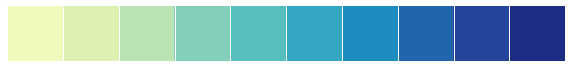

In [7]:
YlGnBu_palette = sns.color_palette("YlGnBu", 10)
sns.palplot(YlGnBu_palette)

#### ✔️ This notebook will use this palettes.

# 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the target data percent
* Plot the Keyword per Count
* Number of alphabets by sentence / Number of words by sentence

### 3-1) Plot the target data percent

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


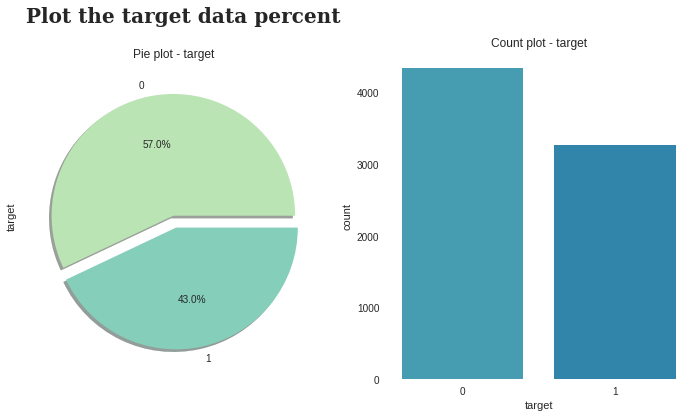

In [8]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
df['target'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True, colors=[YlGnBu_palette[2],YlGnBu_palette[3]])
ax[0].set_title('Pie plot - target')
sns.countplot('target', data=df, ax=ax[1], palette=[YlGnBu_palette[5],YlGnBu_palette[6]])
ax[1].patch.set_alpha(0)
ax[1].set_title('Count plot - target')

fig.text(0.13,0.95,"Plot the target data percent", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()
#target == 0 : negative(fake)
#tarege == 1 : postive(real)

### 3-2) Plot the Keyword per Count

In [9]:
keyword_unique = df['keyword'].unique()
print(keyword_unique[:20])

[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze']


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


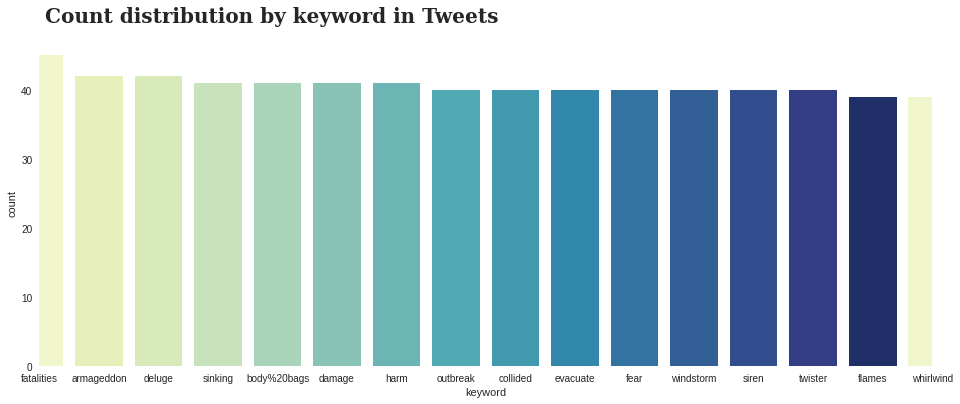

In [10]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
sns.countplot('keyword',data=df,ax=ax,order=df['keyword'].value_counts().index, palette=sns.color_palette("YlGnBu", 15))
ax.set_xlim(0,15)
ax.patch.set_alpha(0)
fig.text(0.13,0.92,"Count distribution by keyword in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

### 3-3) Number of alphabets by sentence / Number of words by sentence

In [11]:
def get_length(text):
    return len(text)

In [12]:
df['length'] = df['text'].apply(get_length)

In [13]:
YlGnBu_palette

[(0.9490657439446367, 0.9801922337562476, 0.7377931564782776),
 (0.8633756247597079, 0.946482122260669, 0.6993310265282584),
 (0.7338869665513265, 0.8956401384083045, 0.7104036908881199),
 (0.521291810841984, 0.812964244521338, 0.7310726643598615),
 (0.34262206843521725, 0.7462668204536717, 0.7558938869665514),
 (0.20396770472895037, 0.6613763936947328, 0.762968089196463),
 (0.11534025374855825, 0.552156862745098, 0.7451903114186851),
 (0.1301038062283737, 0.40156862745098043, 0.6743252595155709),
 (0.13988465974625144, 0.27690888119953866, 0.6151480199923107),
 (0.11343329488658209, 0.17880815071126488, 0.514878892733564)]

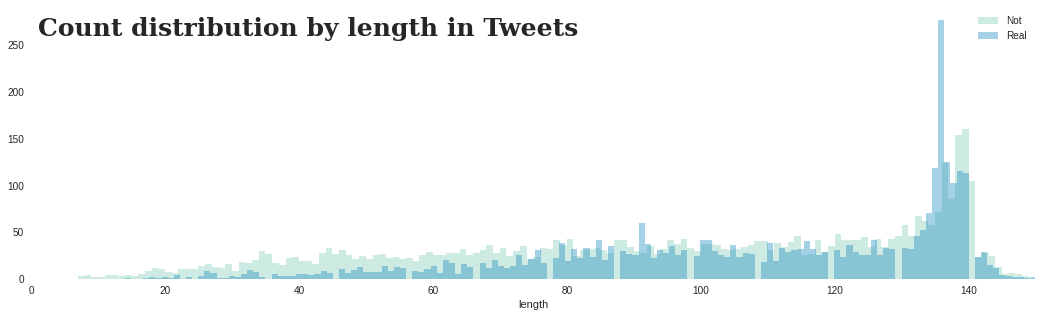

In [14]:
fig, ax = plt.subplots(1,1, figsize=(18,5))
plt.hist(df[df['target'] == 0]['length'], alpha = 0.4, bins=150, label = 'Not', color=YlGnBu_palette[3])
plt.hist(df[df['target'] == 1]['length'], alpha = 0.4, bins=150, label = 'Real', color=YlGnBu_palette[6])
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
ax.set_ylabel('')
ax.patch.set_alpha(0)
fig.text(0.13,0.8,"Count distribution by length in Tweets", fontweight="bold", fontfamily='serif', fontsize=25)
plt.show()

# 4. Prepocessing Data
* Null value processing

In [15]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

In [16]:
df['keyword'].fillna("", inplace = True)
df['location'].fillna("",inplace = True)
df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
length      0
dtype: int64

# 5. Feature Enginnering 
* Text data to nomalization
* Use SpellChecker libray
* Plot WordClouds
* Drop unuseful columns
* Text data tokenization
* Text data to fit on Glove Embedding

### 5-1) Text data to nomalization

In [17]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [18]:
def preprocess(text,stem=False):
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(SnowballStemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

### 5-2) Use SpellChecker libray

In [19]:
spell = SpellChecker()
def correct_spell(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [20]:
text = "corect"
correct_spell(text)

'correct'

In [21]:
df.text = df.text.apply(lambda x: preprocess(x))
#df.text = df.text.apply(lambda x: correct_spell(x))

NameError: name 're' is not defined

### 5-3) Plot Word Cloud
* fake target
* real target

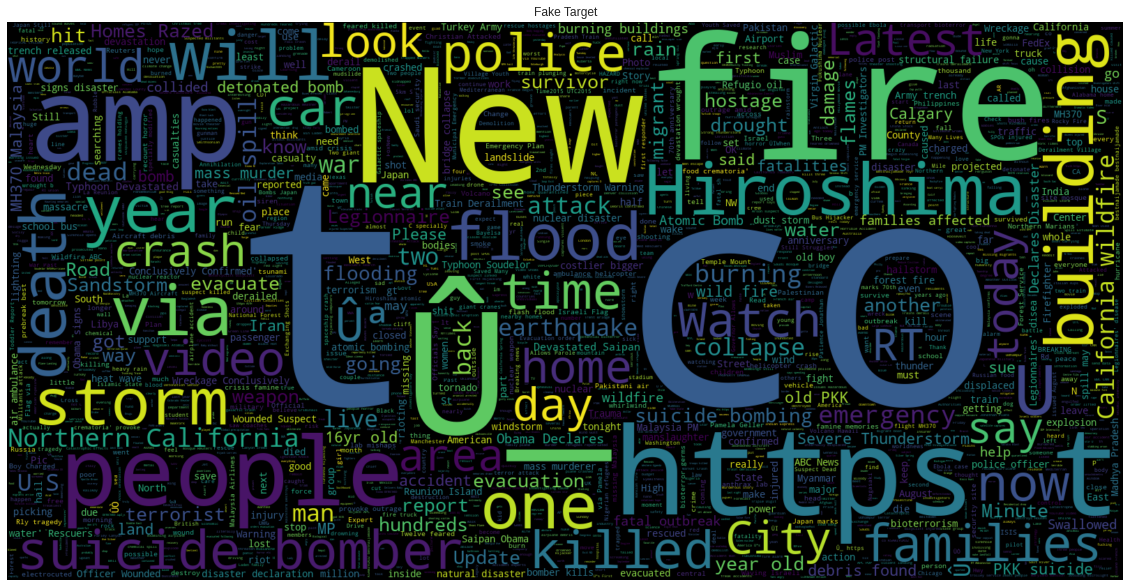

In [22]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.target == 1].text))
plt.axis('off')
plt.title('Fake Target')
plt.imshow(wc,interpolation = 'bilinear')

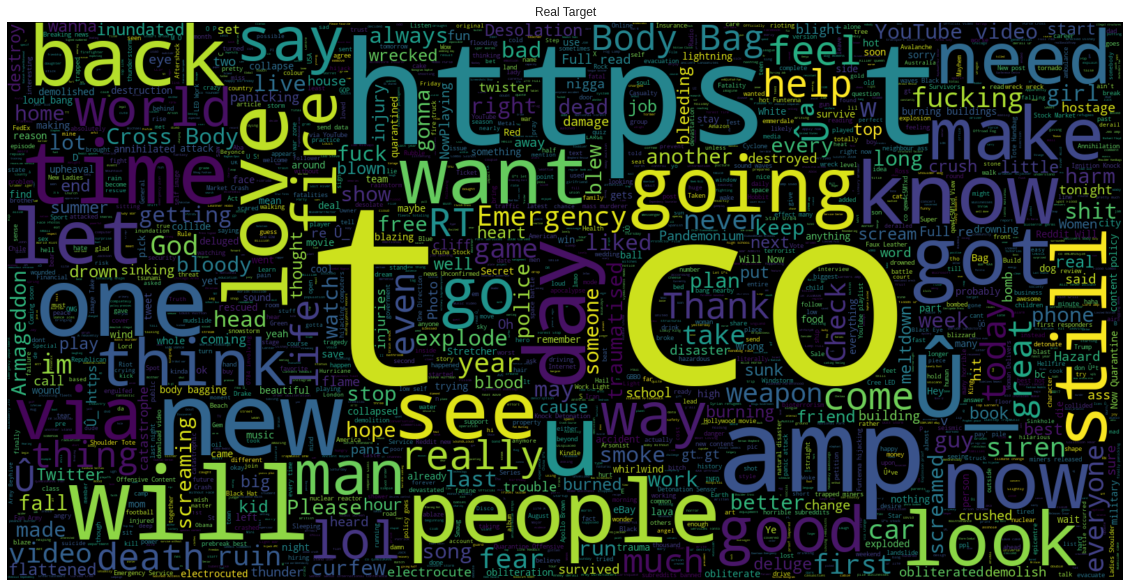

In [23]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.target == 0].text))
plt.axis('off')
plt.title('Real Target')
plt.imshow(wc,interpolation = 'bilinear')

### 5-4) Drop unuseful columns

In [24]:
df.head(10)

,id,keyword,location,text,target,length
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,,,Forest fire near La Ronge Sask. Canada,1,38
2,5,,,All residents asked to 'shelter in place' are ...,1,133
3,6,,,"13,000 people receive #wildfires evacuation or...",1,65
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,88
5,8,,,#RockyFire Update => California Hwy. 20 closed...,1,110
6,10,,,#flood #disaster Heavy rain causes flash flood...,1,95
7,13,,,I'm on top of the hill and I can see a fire in...,1,59
8,14,,,There's an emergency evacuation happening now ...,1,79
9,15,,,I'm afraid that the tornado is coming to our a...,1,52


In [25]:
df.drop(['keyword','id','location','length'],axis=1,inplace=True)
df.head(10)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


### 5-5) Text data tokenization

In [26]:
train_data, test_data = train_test_split(df,test_size = 0.2)
print("Train Data size : ",len(train_data))
print("Test Data size : ",len(test_data))

Train Data size :  6090
Test Data size :  1523


In [27]:
train_data.head(10)

,text,target
6483,The feeling of lonelyness has sunk into me str...,0
4853,@atljw @cnnbrk fine line btw mass murderer and...,0
1686,@tackettdc Like a scene from When Worlds Colli...,1
5653,Rescue of the day: ItÛªs World Cat Day Saturd...,0
2858,w--=-=-=-[ NEMA warns Nigerians to prepare for...,1
1750,Motorcyclist bicyclist injured in Denver colli...,1
6248,@PyrBliss ah I remember those days. In a snows...,1
5297,DTN Italy: Families to sue over Legionnaires: ...,1
1760,Well Saturn doesn't exist anymore. So the coll...,1
5824,Jun 2015. Yemenis search for survivors under t...,1


In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)

Vocab size :  19314


### 5-6) Text data to fit on Glove Embedding

In [29]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = 30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = 30)


print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (6090, 30)
Testing X Shape: (1523, 30)


In [30]:
y_train = train_data.target
y_test = test_data.target

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train,y_test)

y_train shape: (6090,)
y_test shape: (1523,)
6483    0
4853    0
1686    1
5653    0
2858    1
       ..
5829    0
7262    1
583     0
113     0
4610    0
Name: target, Length: 6090, dtype: int64 3106    0
4383    0
6389    1
4907    1
1039    0
       ..
3105    0
4456    1
2189    1
2814    0
1294    0
Name: target, Length: 1523, dtype: int64


In [31]:
GLOVE_EMB = '/kaggle/input/glove6b/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 512

In [32]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [33]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [34]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],                                            
                                            input_length=30,
                                           trainable=False)

# 6. Modeling
* Glove & LSTM Modeling
* Training
* Plot model's loss / accuray values

### 6-1) Glove & LSTM Modeling

In [35]:
inputs = Input(shape=(30,),dtype = 'int32')

embedding = embedding_layer(inputs)
net = SpatialDropout1D(0.2)(embedding)
net = Bidirectional(LSTM(64,dropout=0.2, recurrent_dropout=0.2))(net)
net = Dense(1,activation = 'sigmoid')(net)

outputs = net
model = tf.keras.Model(inputs,outputs)

In [36]:
model.compile(optimizer = Adam(learning_rate = LR),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [37]:
callback = ReduceLROnPlateau(factor=0.1,
                    min_lr = 0.01,
                    monitor = 'val_loss',
                    verbose = 1)

### 6-2) Training

In [38]:
history = model.fit(x_train,
                    y_train,
                    batch_size=512,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    callbacks = [callback])

Epoch 1/10
12/12 [==============================] - 8s 265ms/step - loss: 0.6644 - accuracy: 0.5948 - val_loss: 0.5616 - val_accuracy: 0.7124
Epoch 2/10
12/12 [==============================] - 3s 217ms/step - loss: 0.5398 - accuracy: 0.7337 - val_loss: 0.4900 - val_accuracy: 0.7735
Epoch 3/10
12/12 [==============================] - 3s 255ms/step - loss: 0.4747 - accuracy: 0.7844 - val_loss: 0.4589 - val_accuracy: 0.7925
Epoch 4/10
12/12 [==============================] - 3s 238ms/step - loss: 0.4253 - accuracy: 0.8136 - val_loss: 0.4527 - val_accuracy: 0.7997
Epoch 5/10
12/12 [==============================] - 3s 226ms/step - loss: 0.4146 - accuracy: 0.8180 - val_loss: 0.4532 - val_accuracy: 0.7958
Epoch 6/10
12/12 [==============================] - 3s 213ms/step - loss: 0.4021 - accuracy: 0.8245 - val_loss: 0.4484 - val_accuracy: 0.8004
Epoch 7/10
12/12 [==============================] - 3s 231ms/step - loss: 0.3864 - accuracy: 0.8301 - val_loss: 0.4484 - val_accuracy: 0.8030
Epoch 

### 6-3) Plot model's loss / accuray values

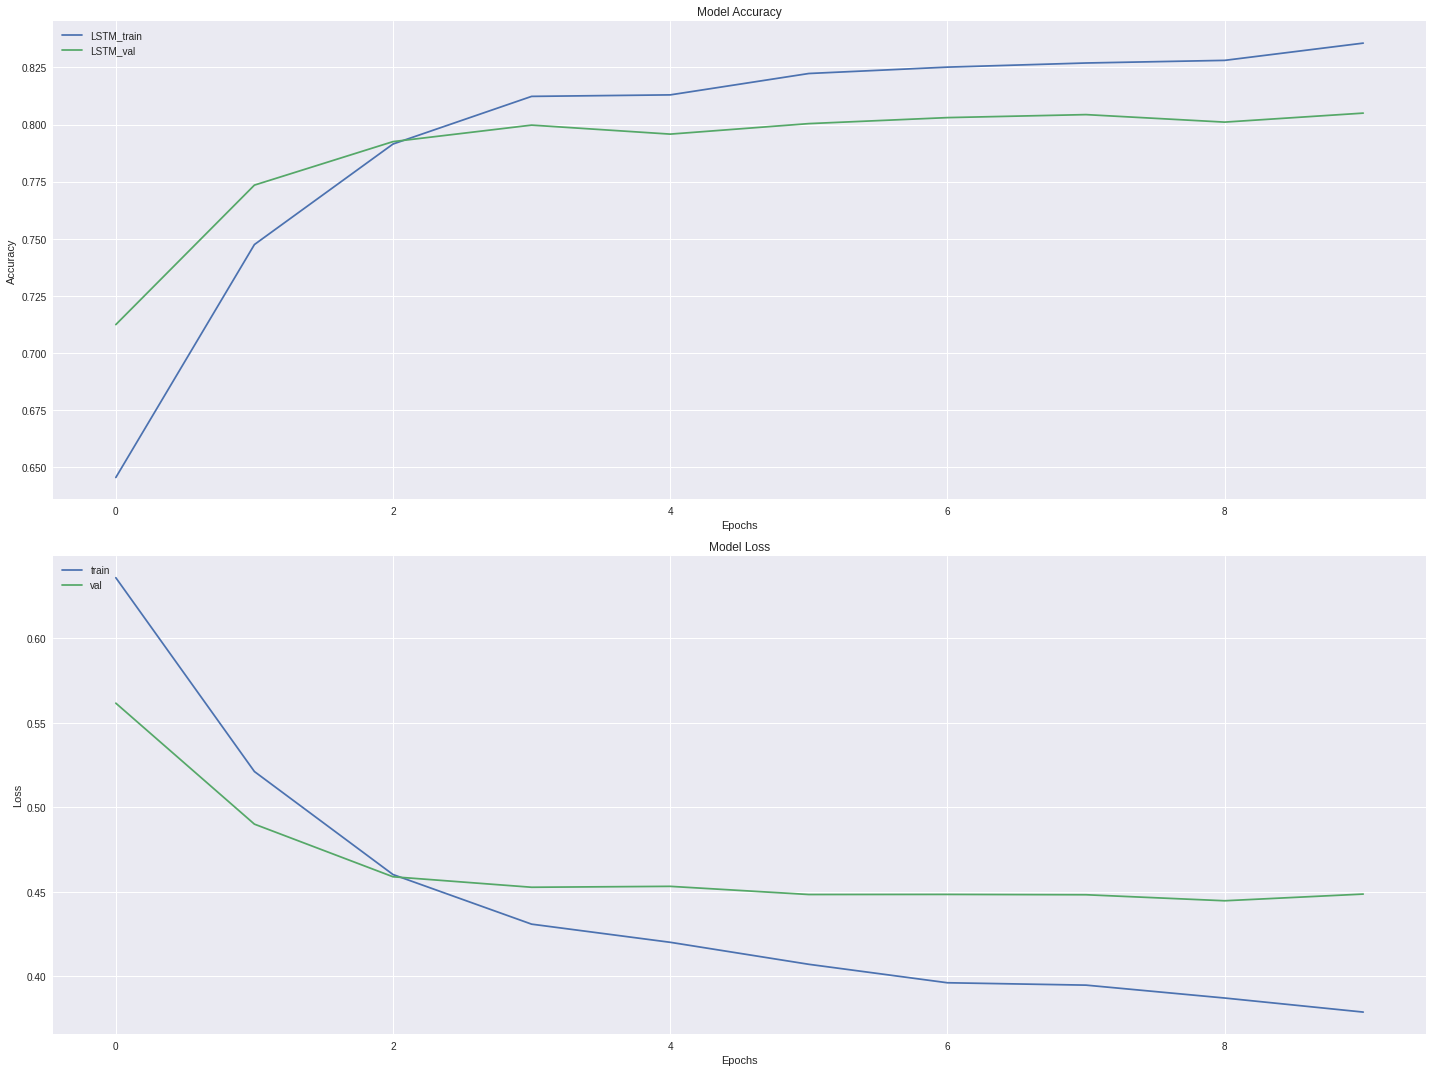

In [39]:

f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

# 7. Submission
* Submit the predictions

In [40]:
sample = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [41]:
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [42]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [43]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [44]:
test.drop(['keyword','id','location',],axis=1,inplace=True)
test.head(10)

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan
5,We're shaking...It's an earthquake
6,They'd probably still show more life than Arse...
7,Hey! How are you?
8,What a nice hat?
9,Fuck off!


In [45]:
test.text = test.text.apply(lambda x: preprocess(x))

NameError: name 're' is not defined

In [46]:
test.shape

(3263, 1)

In [47]:
test = pad_sequences(tokenizer.texts_to_sequences(test.text), maxlen = 30)

print("test Shape:",test.shape)

test Shape: (3263, 30)


In [48]:
prediction = model.predict(test)
prediction = list(1 if x>0.5 else 0 for x in list(prediction))
prediction[:10]

[1, 1, 1, 0, 1, 1, 0, 0, 0, 0]

In [49]:
sample['target'] = prediction
sample['target'].value_counts()

0    2050
1    1213
Name: target, dtype: int64

In [50]:
sample.to_csv('submission.csv',index=False)

##### reference 
* https://www.kaggle.com/mnavaidd/tweet-classification-using-lstm-bert/notebook?select=glove.6B.zip
* https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

###  If this notebook is useful for your kaggling, "UPVOTE" for it 👀
#### THX to Reading My Notebook🌈